# <font color='#f78fb3'> Netflix Recommendations System - Word2Vec  |<br> </font>  
# <font color='#3dc1d3'>  
1.  Preprocess data
2.  Transfer Learning, using Google Pretrained Data
3.  Create Word2Vec Model
4.  Content based Recommendation System; Find 'what to watch' based which you movie you watched <br>

## <font color='#f9ca24'> Word Embedding
 <font color='00BFEB'>

In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
!pip install gensim==3.6.0 #Install gensim, a useful NLP library that we will use to load w2v embeddings
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors
import warnings  
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')  
warnings.filterwarnings(action='ignore',category=FutureWarning,module='gensim')  
pd.set_option("display.max_rows", None, "display.max_columns", None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shakabrah/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     |████████████████████████████████| 23.1 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 10.7 MB/s  eta 0:00:01
  Created wheel for gensim: filename=gensim-3.6.0-cp38-cp38-linux_x86_64.whl size=24779154 sha256=1020b43175f1e9e84354670485d1e28b6522f6742dad13bf009e32f42fcb5076
  Stored in directory: /home/shakabrah/.cache/pip/wheels/d6/5b/91/658efb08f9d790987e1ef3795e62e129868afb0fde409baac5
Successfully built gensim


In [3]:
from ipykernel import kernelapp as app

<font color='#f78fb3'>Load data 

from google.colab import files 
upload = files.upload()

!unzip netflix

### <font color='#f78fb3'>Explore dataset

In [4]:
dataset_path = '../../datasets/netflix_titles.csv'
df = pd.read_csv(dataset_path)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [5]:
df['description'].count()

6234

In [6]:
df['description'][0]

'Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first.'

In [7]:
df['title'][1000]

"All's Well, End's Well (2009)"

In [8]:
df['description'][1000]

'Bound by a family rule that forbids him from marrying until his stubborn sister gets hitched, a bachelor enlists the help of a love guru to woo her.'

### <font color='#f78fb3'>only show columns of interest

In [9]:
df2 = df[["title", "description","listed_in"]]
df2.head(10)

,title,description,listed_in
0,Norm of the North: King Sized Adventure,Before planning an awesome wedding for his gra...,"Children & Family Movies, Comedies"
1,Jandino: Whatever it Takes,Jandino Asporaat riffs on the challenges of ra...,Stand-Up Comedy
2,Transformers Prime,"With the help of three human allies, the Autob...",Kids' TV
3,Transformers: Robots in Disguise,When a prison ship crash unleashes hundreds of...,Kids' TV
4,#realityhigh,When nerdy high schooler Dani finally attracts...,Comedies
5,Apaches,A young journalist is forced into a life of cr...,"Crime TV Shows, International TV Shows, Spanis..."
6,Automata,"In a dystopian future, an insurance adjuster f...","International Movies, Sci-Fi & Fantasy, Thrillers"
7,Fabrizio Copano: Solo pienso en mi,Fabrizio Copano takes audience participation t...,Stand-Up Comedy
8,Fire Chasers,"As California's 2016 fire season rages, brave ...","Docuseries, Science & Nature TV"
9,Good People,A struggling couple can't believe their luck w...,"Action & Adventure, Thrillers"


In [10]:
df.type.unique()

array(['Movie', 'TV Show'], dtype=object)

### <font color='#f78fb3'>drop null values in description column

In [11]:
df.isnull().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

### <font color='#f78fb3'>Visualize the length of descriptions

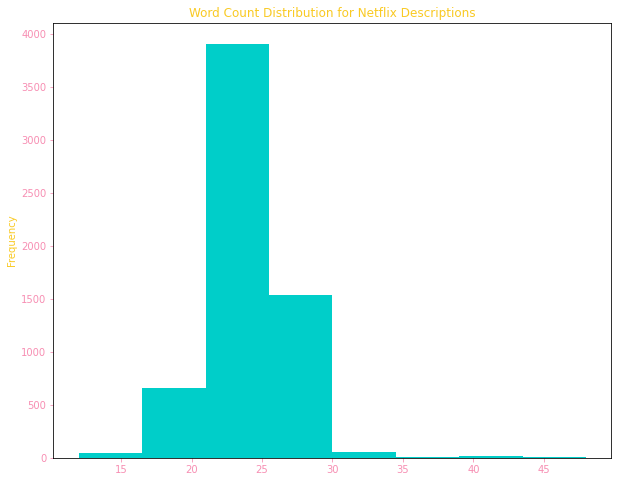

In [12]:
df["word_count"] = df['description'].apply(lambda x: len(str(x).split()))
ax = df['word_count'].plot(
    kind='hist',
    bins=8,
    color='#00cec9',
    figsize = (10,8), title="Word Count Distribution for Netflix Descriptions"
)
#add in the colour
ax.title.set_color("#f9ca24")
ax.yaxis.label.set_color("#f9ca24")
ax.xaxis.label.set_color("#f9ca24")
ax.tick_params(axis='x', colors='#f78fb3')
ax.tick_params(axis='y', colors='#f78fb3')


<font color='#3dc1d3'> Ensure Descriptions only contain strings; not float dtyp; Pandas astype() is the one of the most important methods. It is used to change data type of a series. When data frame is made from a csv file, the columns are imported and data type is set automatically which many times is not what it actually should have. For example, a salary column could be imported as string but to do operations we have to convert it into float. In this case, the series in description column; the dtype needs to be converted to string, ensure it is not float
astype() is used to do such data type conversions.

In [13]:
df['description'] = df['description'].astype(str)

 ### <font color='#f9ca24'> Preprocessing (cleaning) the Descriptions. <br>
 <font color='#3dc1d3'> Non-ASCII characters: भारत hindi;
.网络 Chinese; Hebrew
.קום, Arabic <br> Ascii - english based letters/digits/

In [14]:
def non_ascii(s):
  return "".join(i for i in s if ord(i)<128)

def lower(text):
  return text.lower()

def stop_words(text):
  text = text.split()#split tokens to find stop words
  stops = set(stopwords.words("english"))
  text = [w for w in text if not w in stops]
  text = " ".join(text)
  #join into a string after removing stop words 
  return text 

def clean_html(text):
  html = re.compile('<.*?>')#regex
  return html.sub(r'',text)

def punct(text):
  token=RegexpTokenizer(r'\w+')#regex
  text = token.tokenize(text)
  text= " ".join(text)
  return text 

 <font color='#3dc1d3'>A new column is created to store the cleaned, preprocessed descriptions.

In [15]:
df['new_desc'] = df['description'].apply(non_ascii)
df['new_desc'] = df.new_desc.apply(func = lower)
df['new_desc'] = df.new_desc.apply(func = stop_words)
df['new_desc'] = df.new_desc.apply(func = punct)
df['new_desc'] = df.new_desc.apply(func = clean_html)

In [16]:
print(df.iloc[1]['new_desc'])
print(df.iloc[1]['description'])

jandino asporaat riffs challenges raising kids serenades audience rousing rendition sex fire comedy show
Jandino Asporaat riffs on the challenges of raising kids and serenades the audience with a rousing rendition of "Sex on Fire" in his comedy show.


<font color='#f9ca24'>Start Work on the Word2Vec Model<br><font color='#f78fb3'>Splitting the descriptions into words and stored in a list called ‘universe’; universe is essentially our corpus used for training our word2vec model<br>The word2vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. The resulting word vector file can be used as features in many natural language processing and machine learning applications.<br><font color='#f78fb3'>Word tokenization; break up description into word chunks

In [17]:
universe = []
for words in df['new_desc']:
  universe.append(words.split())
  #appends split-word element to the end of the list - universe 

In [18]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,word_count,new_desc
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,23,planning awesome wedding grandfather polar bea...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,25,jandino asporaat riffs challenges raising kids...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",23,help three human allies autobots protect earth...
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,20,prison ship crash unleashes hundreds deceptico...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,26,nerdy high schooler dani finally attracts inte...


<font color='#f9ca24'>Transfer Learning<br><font color='#f78fb3'>using the word2vec pre-trained Google News model (GoogleNews-vectors-negative300) with the gensim Python library.<br>get GoogleNews pretrained data<br> takes a few seconds to load in gensim

In [21]:
!wget -P "../../saved_models/" -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2022-02-22 10:30:58--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.25.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.25.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1,5G) [application/x-gzip]
Saving to: ‘../../saved_models/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1,53G  3,81MB/s    in 7m 50s  

2022-02-22 10:38:49 (3,34 MB/s) - ‘../../saved_models/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



<font color='#f78fb3'>embedding_file as the GoogleNews-vectors-negative300 file

In [20]:
EMBEDDING_FILE = '../../saved_models/GoogleNews-vectors-negative300.bin.gz'

<font color='#f78fb3'>Training corpus with Google Pretrained Model 

In [20]:
pretrained_model = Word2Vec(size = 300, window=5, min_count = 2, workers=-1)
pretrained_model.build_vocab(universe)
pretrained_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary = True)
pretrained_model.train(universe, total_examples=pretrained_model.corpus_count, epochs = 5)

(0, 0)

<font color='#f78fb3'>Above: intersect_word2vec_format() <br>Merge the input-hidden weight matrix from the original word2vec format given, where it intersects with the current vocabulary/universe corpus. (What you need to note here: No words are added to the existing vocabulary, but intersecting words adopt the file’s weights, and non-intersecting words are left alone.)<br>binary is a boolean indicating whether the data is in binary word2vec format.<br>lockf is a lock-factor value to be set for any imported word-vectors; the default value of 0.0 prevents further updating of the vector during subsequent training. Use 1.0 to allow further training updates of merged vectors.<br>
<br>
The parameters:
min_count =  Ignores all words with total absolute frequency lower than this - (2, 100)<br>
window = The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)<br>
size = int - Dimensionality of the feature vectors. - (50, 300)<br>
sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5) <br> 
workers = int - Use these many worker threads to train the model (=faster training with multicore machines)<br>
Word2Vec needs a vocabulary; (taking in the tokens and filtering out the unique ones

<font color='#3dc1d3'>Try out the similarity between words; after intersecting with our corpus-universe

In [23]:
pretrained_model.wv.most_similar(positive=["prince"])
#paramater positive: gives a list of keys that contribute positively 

[('princess', 0.6986508369445801),
 ('monarch', 0.6686813235282898),
 ('royal', 0.6433807611465454),
 ('king', 0.6159994602203369),
 ('throne', 0.5817441344261169),
 ('palace', 0.5728129148483276),
 ('queen', 0.5534095168113708),
 ('nobleman', 0.5447623133659363),
 ('knight', 0.5390364527702332),
 ('kingdom', 0.5133711099624634)]

In [63]:
pretrained_model.wv.most_similar(positive=["hand"])

[('hands', 0.6113166809082031),
 ('arm', 0.4354873597621918),
 ('thumb', 0.4265793561935425),
 ('handed', 0.4130321741104126),
 ('paw', 0.40222683548927307),
 ('fist', 0.395877480506897),
 ('side', 0.37118443846702576),
 ('cheek', 0.3695729672908783),
 ('chest', 0.3638487458229065),
 ('nose', 0.3625941276550293)]

In [24]:
pretrained_model.wv.similarity("king","queen")

0.6510956

In [25]:
pretrained_model.wv.similarity("hand","queen")

0.051104233

<font color='#f78fb3'>The function Vectorize() defines the average word2vec for each Netflix description

In [26]:
def vectorize(x):

  global embeddings
  embeddings = []
  #a list to store the vectors; these are vectorized Netflix Descriptions
  for line in df['new_desc']: #for each cleaned description
    w2v = None
    count = 0
    for word in line.split():
      if word in pretrained_model.wv.vocab:
        count += 1
        if w2v is None:
          w2v = pretrained_model.wv[word]
        else:
          w2v = w2v + pretrained_model.wv[word]
    if w2v is not None:
      w2v = w2v / count
      #append element to the end of the embeddings list 
      embeddings.append(w2v)

<font color='#f78fb3'>define the function to find the top 5 most similar/recommended Netflix shows, based on the one you previously watched.<br>Invert index; we have a dictionary of characters/embeddings from Description mapped to their titles, and we want to convert that to a dictionary of titles mapped to the characters that have them.<br> We trained on the descriptions of the Netflix shows but we want to search/match based on a title. 

In [75]:
def netflix_because_you_watched(title):
  vectorize(df)
  cosine_similarities = cosine_similarity(embeddings,embeddings)
  netflix_shows = df[['title']]#new dataframe with reversed indexes
  indices = pd.Series(df.index, index = df['title']).drop_duplicates()
  ix = indices[title]
  cosine_sim = list(enumerate(cosine_similarities[ix]))
  #enumerate adds a counter to an iteratable and returns it 
  cosine_sim = sorted(cosine_sim, key = lambda x: x[1], reverse = True)
  cosine_sim = cosine_sim[1:6] #we want the top 5 similar netflix shows 
  netflix_index = [i[0] for i in cosine_sim]
  watch_next = netflix_shows.iloc[netflix_index]
  for index, row in watch_next.iterrows():
    print(row['title'])


<font color='#3dc1d3'>sorted() function returns a sorted list of the specified iterable object.

You can specify ascending or descending order. Strings are sorted alphabetically, and numbers are sorted numerically.
Example below: 

In [78]:
a = (1, 11, 2)
x = sorted(a)
print(x)

[1, 2, 11]


<font color='#f9ca24'> Netflix Recommendations 

In [76]:
netflix_because_you_watched("Apaches")

Longmire
Hide and Seek
In Family I Trust
Imperial Dreams
Khelti Hai Zindagi Aankh Micholi


In [77]:
netflix_because_you_watched("Friends")

Big Mouth
Hap and Leonard
LEGO Friends: The Power of Friendship
Single Ladies Senior
Workin' Moms


In [79]:
netflix_because_you_watched("Transformers Prime")

The Shannara Chronicles
Transformers: Robots in Disguise
Power Rangers: Megaforce
Westerplatte Resists
Naruto Shippûden the Movie: The Will of Fire
